In [9]:
import torch
import sys
from torch_geometric.data import Data
from opencood.data_utils.datasets.basedataset import BaseDataset


def calc_distance(node_a, node_b):
    """
    Calculate Euclidean distance between two nodes.
    """
    return ((node_a[0] - node_b[0]) ** 2 + (node_a[1] - node_b[1]) ** 2) ** 0.5


def construct_graph_from_dataset(dataset, idx, range_threshold=100):
    """
    Construct a graph from the BaseDataset for a given index.

    Parameters:
    - dataset: The BaseDataset object.
    - idx: Index of the scenario to process.
    - range_threshold: Distance threshold for connecting nodes.

    Returns:
    - PyTorch Geometric Data object representing the graph.
    """
    # Retrieve base data for the current index
    base_data = dataset.retrieve_base_data(idx)

    # Nodes and features
    nodes = []
    node_features = []

    for cav_id, cav_content in base_data.items():
        # Extract node features from cav_content
        params = cav_content['params']
        lidar_pose = params['lidar_pose']  # Get position
        velocity = params.get('ego_speed', 0)  # Default to 0 if missing
        trajectory = 0#params.get('plan_trajectory')

        nodes.append(cav_id)
        node_features.append([lidar_pose[0], lidar_pose[1], velocity,trajectory])

    # Edges and features
    edge_index = []
    edge_features = []

    for i, node_a in enumerate(nodes):
        for j, node_b in enumerate(nodes):
            if node_a != node_b:  # Avoid self-loops
                dist = calc_distance(node_features[i], node_features[j])
                if dist < range_threshold:  # Only include edges within the range threshold
                    edge_index.append([i, j])
                    edge_features.append([dist])  # Use distance as an edge feature

    # Convert to PyTorch tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    node_features = torch.tensor(node_features, dtype=torch.float)
    edge_features = torch.tensor(edge_features, dtype=torch.float)

    # Return the graph as a PyTorch Geometric Data object
    return Data(x=node_features, edge_index=edge_index, edge_attr=edge_features)


def test_construct_graph(params, root_dir, index_to_test):
    """
    Test the graph construction process using the BaseDataset class.

    Parameters:
    - params: Dictionary of parameters for the dataset.
    - root_dir: Path to the dataset root directory.
    - index_to_test: Index of the scenario to test.

    Returns:
    - Constructed graph.
    """
    # Initialize the dataset
    dataset = BaseDataset(params, visualize=False, train=True)
    print(f"Dataset initialized with {len(dataset)} samples.")

    # Construct the graph for a specific index
    graph = construct_graph_from_dataset(dataset, index_to_test)
    print("Graph constructed:")
    print(f"- Nodes: {graph.num_nodes}")
    print(f"- Edges: {graph.num_edges}")
    print(f"- Node features shape: {graph.x.shape}")
    print(f"- Edge features shape: {graph.edge_attr.shape}")

    return graph


In [10]:

params = {
        'root_dir': '/home/xavierallem/Opencood_testing/OpenCOOD/OPV2V/scenario_train',  # Replace with your dataset path
        'data_augment': {},  # Add any data augmentation parameters if needed
        'train_params': {'max_cav': 10},
    }

# Path to the dataset root directory
root_dir = params['root_dir']

    # Index of the scenario to test
index_to_test = 10

graph = test_construct_graph(params, root_dir, index_to_test)

    # Example usage of the graph
print("Graph node features:", graph.x)
print("Graph edge features:", graph.edge_attr)

Dataset initialized with 493 samples.
Graph constructed:
- Nodes: 3
- Edges: 6
- Node features shape: torch.Size([3, 4])
- Edge features shape: torch.Size([6, 1])
Graph node features: tensor([[ 52.4258, 139.6302,  19.9143,   0.0000],
        [ 86.3504, 143.2669,  32.7509,   0.0000],
        [105.8908, 136.3349,  33.0199,   0.0000]])
Graph edge features: tensor([[34.1190],
        [53.5664],
        [34.1190],
        [20.7335],
        [53.5664],
        [20.7335]])


In [11]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def convert_to_networkx(data):
    """
    Convert PyTorch Geometric data to NetworkX graph.
    """
    # Convert to NetworkX graph with edge attributes
    G = to_networkx(data, to_undirected=True, edge_attrs=['edge_attr'])
    return G

def visualize_graph(G, node_features):
    """
    Visualize the graph using NetworkX and Matplotlib.
    """
    plt.figure(figsize=(8, 8))
    
    # Use x, y positions from node features to position nodes
    pos = {i: (node_features[i, 0], node_features[i, 1]) for i in range(len(node_features))}

    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_weight='bold')
    
    # Draw edge labels (optional)
    edge_labels = {(i, j): f"{d['edge_attr'][0]:.2f}" for i, j, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    plt.title("Graph Visualization")
    plt.show()

TypeError: 'float' object is not subscriptable

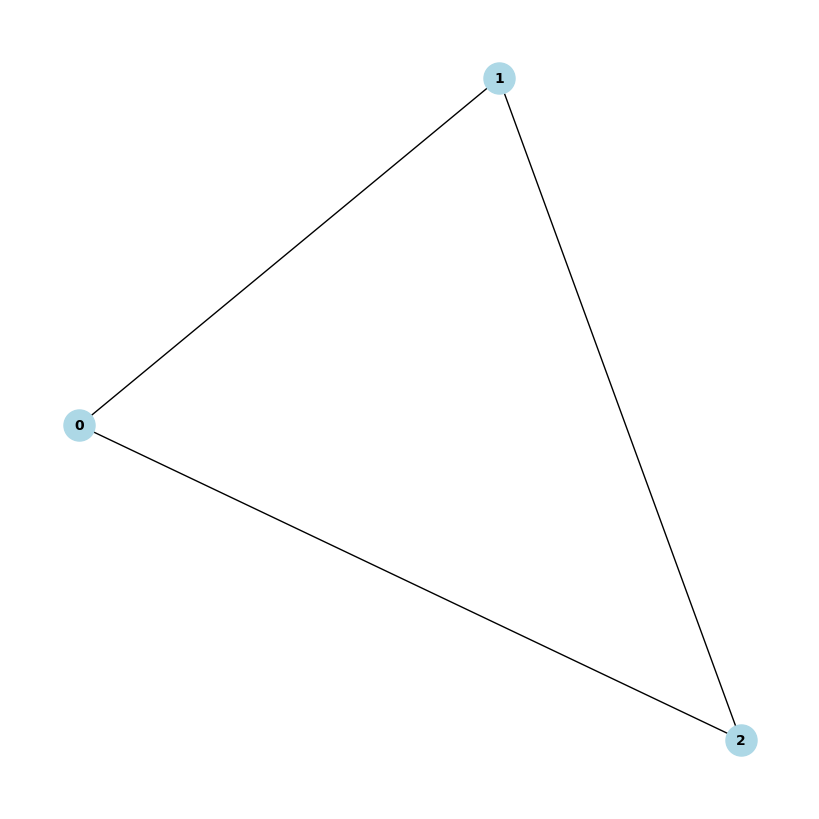

In [12]:
G = convert_to_networkx(graph)
visualize_graph(G, graph.x.numpy())